In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src")

In [2]:
from evaluation_utils import *
from models import LastValueRegressor

In [3]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

In [4]:
data_dir = "../trades_on_sushiswap"
filename = "CVX_WETH.csv"
df = pd.read_csv(os.path.join(data_dir, filename))
df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.000Z')
df = df.set_index("timestamp").sort_index()

In [5]:
### Global parameters
win_size = 7
k_folds = 5

In [6]:
results = {"autoregressive": {'model': [], 'mean': [], 'stddev': []},\
           "one-step": {'model': [], 'mean': [], 'stddev': []}}

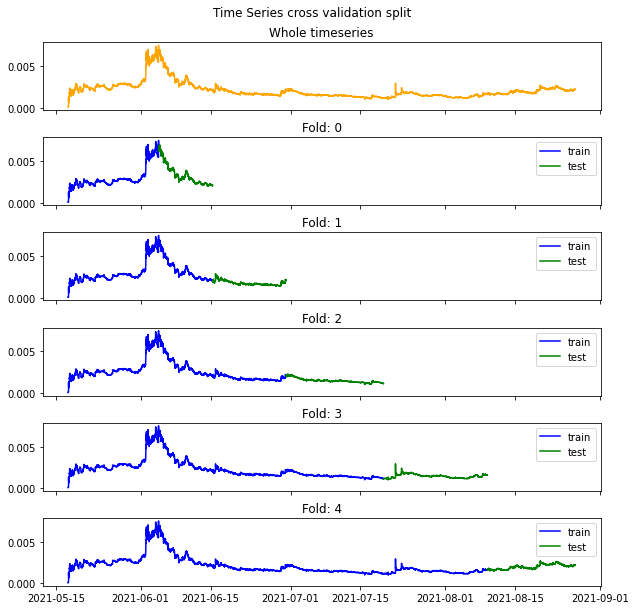

In [7]:
fig, axes = plt.subplots(6, 1, figsize=(10, 10), sharex=True, sharey=True)

# 5 folds cross validation 
ts_cv = TimeSeriesSplit(n_splits=k_folds)

axes[0].plot(df.price, color='orange')
axes[0].set_title("Whole timeseries")
for fold, (train_idx, test_idx) in enumerate(ts_cv.split(df.price)):
    axes[fold+1].plot(df.price.iloc[train_idx], color='blue', label='train')
    axes[fold+1].plot(df.price.iloc[test_idx], color='green', label='test')
    axes[fold+1].legend()
    axes[fold+1].set_title(f"Fold: {fold}")
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Time Series cross validation split", y=0.93);

### Dummy baseline - always predict the same price as the one before

In [8]:
df1 = df.copy()
for i in range(1, win_size):
    df1[f"price_{i}"] = df.price.shift(i)

y = df1.dropna().price
X = df1.dropna()[[f"price_{i}" for i in range(1, win_size)]]

In [9]:
X.head()

,price_1,price_2,price_3,price_4,price_5,price_6
timestamp,,,,,,
2021-05-17 13:20:33,0.000152,0.000129,0.000115,0.000098,0.000084,0.000075
2021-05-17 13:20:33,0.000239,0.000152,0.000129,0.000115,0.000098,0.000084
2021-05-17 13:20:33,0.000183,0.000239,0.000152,0.000129,0.000115,0.000098
2021-05-17 13:21:25,0.000274,0.000183,0.000239,0.000152,0.000129,0.000115
2021-05-17 13:22:50,0.000281,0.000274,0.000183,0.000239,0.000152,0.000129


In [10]:
y.head()

timestamp
2021-05-17 13:20:33    0.000239
2021-05-17 13:20:33    0.000183
2021-05-17 13:20:33    0.000274
2021-05-17 13:21:25    0.000281
2021-05-17 13:22:50    0.000321
Name: price, dtype: float64

In [11]:
dummy_regressor = LastValueRegressor(win_size=win_size)
model_name = 'dummy regressor'
timeseries_split = TimeSeriesSplit(n_splits=k_folds)
cv = one_step_cross_validation(dummy_regressor, timeseries_split, X, y)
cv

(131.59078316425456, 4.124094324583512)

In [12]:
dummy_regressor = LastValueRegressor(win_size=win_size)
model_name = 'dummy regressor'
timeseries_split = TimeSeriesSplit(n_splits=k_folds)
mean_cv, std_cv = autoregressive_cross_validation(dummy_regressor, timeseries_split, X, y)
results = add_result(results, model_name, mean_cv, std_cv, 'autoregressive')
mean_cv, std_cv = one_step_cross_validation(dummy_regressor, timeseries_split, X, y)
results = add_result(results, model_name, mean_cv, std_cv, 'one-step')

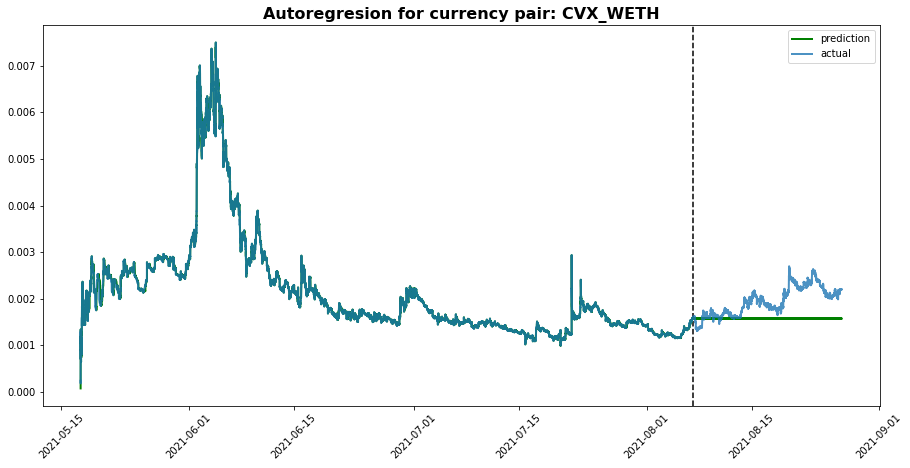

In [13]:
plot_last_fold_autoregression(LastValueRegressor(win_size=win_size), X, y, pair=filename[:-4])

### Linear Regression based on price only - predicts one step at a time

In [14]:
df1 = df.copy()
for i in range(1, win_size):
    df1[f"price_{i}"] = df.price.shift(i)

y = df1.dropna().price
X = df1.dropna()[[f"price_{i}" for i in range(1, win_size)]]

In [15]:
X.head()

,price_1,price_2,price_3,price_4,price_5,price_6
timestamp,,,,,,
2021-05-17 13:20:33,0.000152,0.000129,0.000115,0.000098,0.000084,0.000075
2021-05-17 13:20:33,0.000239,0.000152,0.000129,0.000115,0.000098,0.000084
2021-05-17 13:20:33,0.000183,0.000239,0.000152,0.000129,0.000115,0.000098
2021-05-17 13:21:25,0.000274,0.000183,0.000239,0.000152,0.000129,0.000115
2021-05-17 13:22:50,0.000281,0.000274,0.000183,0.000239,0.000152,0.000129


In [16]:
y.head()

timestamp
2021-05-17 13:20:33    0.000239
2021-05-17 13:20:33    0.000183
2021-05-17 13:20:33    0.000274
2021-05-17 13:21:25    0.000281
2021-05-17 13:22:50    0.000321
Name: price, dtype: float64

In [17]:
lr = LinearRegression()
model_name = 'linear regression price'
timeseries_split = TimeSeriesSplit(n_splits=k_folds)
mean_cv, std_cv = autoregressive_cross_validation(lr, timeseries_split, X, y)
results = add_result(results, model_name, mean_cv, std_cv, 'autoregressive')
mean_cv, std_cv = one_step_cross_validation(lr, timeseries_split, X, y)
results = add_result(results, model_name, mean_cv, std_cv, 'one-step')

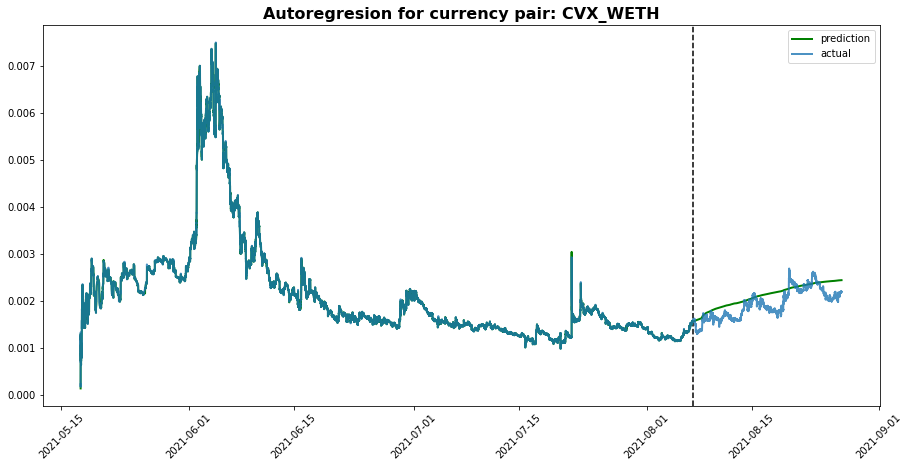

In [18]:
plot_last_fold_autoregression(LinearRegression(), X, y, pair=filename[:-4])

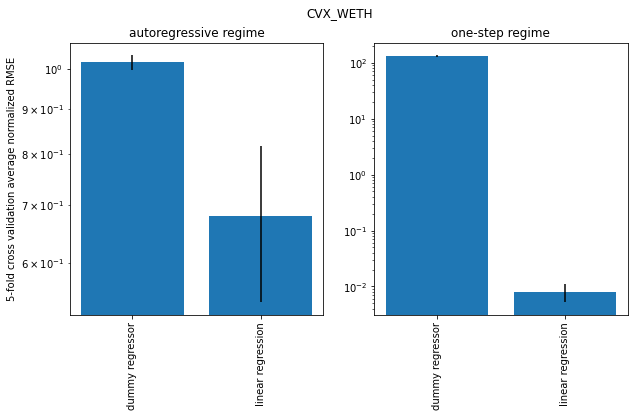

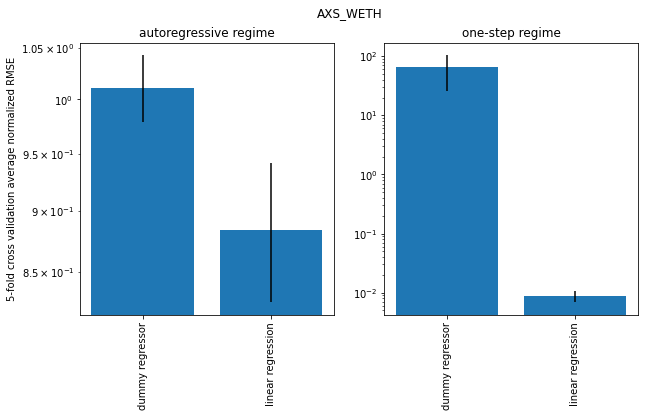

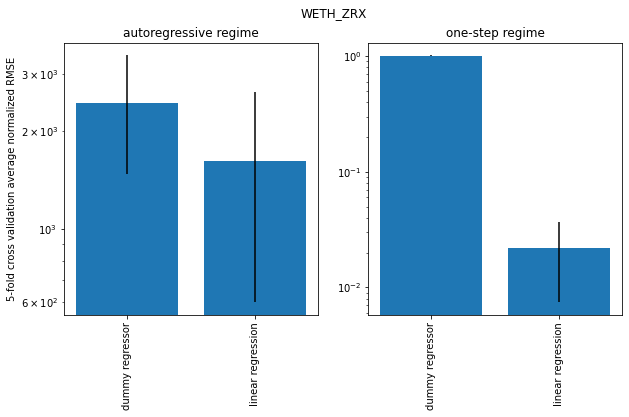

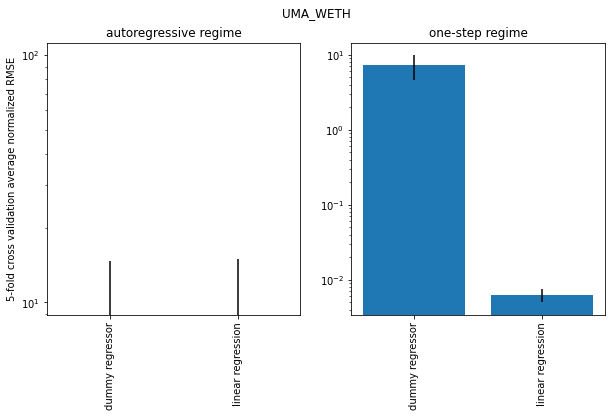

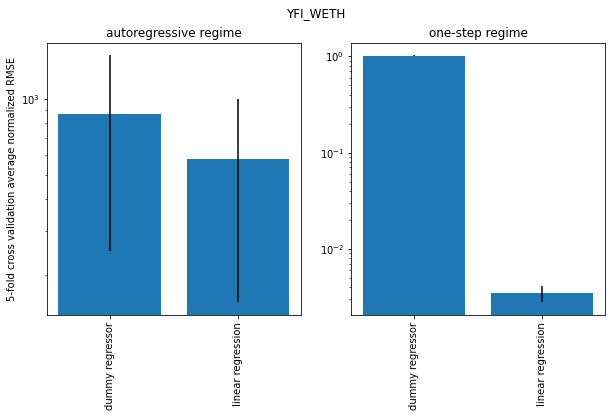

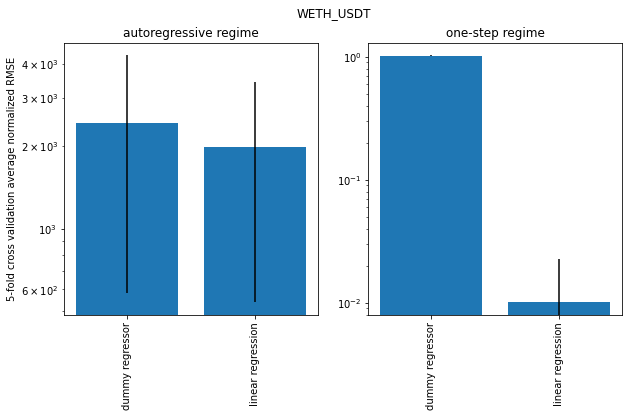

In [22]:
import pickle

# Run coin_pair_pipeline.py to get scores
with open("/home/jczestochowska/workspace/epfl/ma-4/ml4f/ml4f-project/outputs/coin_pair_results.pkl", "rb") as f:
    results = pickle.load(f)

PAIRS = ['CVX_WETH', 'AXS_WETH', 'WETH_ZRX', 'UMA_WETH', 'YFI_WETH',
       'WETH_USDT']
# erorr bars are standard deviations across folds
for pair in PAIRS:
    plot_comparison(results[pair], pair=pair)